# Librerie utilizzate

In [11]:
from matplotlib import pyplot as plt

import matplotlib.dates as md
import numpy as np
from osgeo import gdal
from datetime import datetime
import time
import os
from os import listdir
from os.path import isfile, join,isdir
import rasterio
from rasterio import features,MemoryFile
from rasterio.enums import Resampling
import pprint
import rasterio.mask
import fiona

# Scan and sort the name of files

In [12]:
img_path = join(os.path.abspath(os.getcwd()),"bands","content","data")
scal_path = join(os.path.abspath(os.getcwd()),"sclOrdered")

img_list =[x.split('.')[0] for x in os.listdir(img_path)]
img_list.sort(key=lambda date: datetime.strptime(date, "%Y-%m-%d"))
print("Files and directories in '", img_path, "' :")
 
# prints all files
print(img_list)

print(img_list.index('2017-04-21'))


Files and directories in ' c:\Users\Leo\Desktop\AgriVision2022\bands\content\data ' :
['2016-11-05', '2016-11-12', '2016-11-15', '2016-11-22', '2016-11-25', '2016-12-02', '2016-12-05', '2016-12-12', '2016-12-15', '2016-12-22', '2016-12-25', '2017-01-01', '2017-01-04', '2017-01-14', '2017-01-24', '2017-01-31', '2017-02-03', '2017-02-10', '2017-02-13', '2017-02-20', '2017-02-23', '2017-03-02', '2017-03-05', '2017-03-12', '2017-03-15', '2017-03-22', '2017-03-25', '2017-04-01', '2017-04-04', '2017-04-11', '2017-04-14', '2017-04-21', '2017-04-24', '2017-05-01', '2017-05-04', '2017-05-11', '2017-05-14', '2017-05-21', '2017-05-24', '2017-05-31', '2017-06-03', '2017-06-10', '2017-06-13', '2017-06-20', '2017-06-23', '2017-06-30', '2017-07-03', '2017-07-08', '2017-07-10', '2017-07-13', '2017-07-15', '2017-07-18', '2017-07-20', '2017-07-23', '2017-07-25', '2017-07-28', '2017-07-30']
31


# Read shape from file

In [13]:
#Make sure all shapes are on the same coordinate system 
with fiona.open(join(os.path.abspath(os.getcwd()),"campo4","campo 4 totale.shp"), "r") as shapefile:
    print("coordinate system: ")
    print(shapefile.crs)
    campo4Shape = [feature["geometry"] for feature in shapefile]

with fiona.open(join(os.path.abspath(os.getcwd()),"campo6","campo 6 totale.shp"), "r") as shapefile:
    print(shapefile.crs)
    campo6Shape = [feature["geometry"] for feature in shapefile]

with fiona.open(join(os.path.abspath(os.getcwd()),"campo3","campo3.shp"), "r") as shapefile:
    print(shapefile.crs)
    campo3Shape = [feature["geometry"] for feature in shapefile]


coordinate system: 
{'init': 'epsg:32633'}
{'init': 'epsg:32633'}
{'init': 'epsg:32633'}


# Test the validity of image and shape

EPSG:32633
EPSG:32632


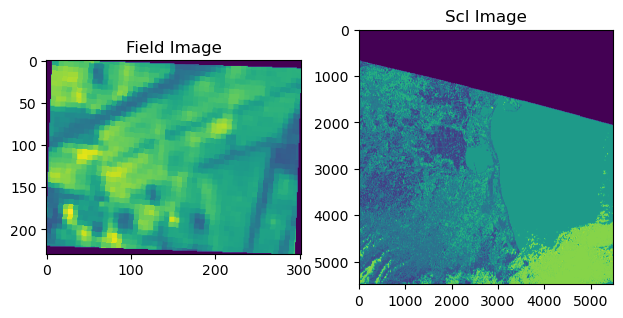

In [81]:
image = rasterio.open(join(img_path,img_list[2]+".tiff"))
print(image.crs)
scl = rasterio.open(join(scal_path,img_list[2]+".jp2"))
print(scl.crs)
shapes32632 = rasterio.warp.transform_geom('EPSG:32633', 'EPSG:32632', campo4Shape, precision=6)
f, axarr = plt.subplots(1,2)
f.tight_layout()
axarr[0].imshow(image.read(1))
axarr[0].set_title("Field Image")
axarr[1].imshow(scl.read(1))
axarr[1].set_title("Scl Image")
outImage, outImageTransf = rasterio.mask.mask(image, campo4Shape, crop=True)
outScl, outSclTransf = rasterio.mask.mask(scl, shapes32632, crop=True)
plt.show()

# Read band file and scl masks

In [15]:

ShapedScl3 = []
ShapedScl4 = []
ShapedScl6 = []

ShapedImage3 = []
ShapedImage4 = []
ShapedImage6 = []

campo3Shape32632 = rasterio.warp.transform_geom('EPSG:32633', 'EPSG:32632', campo3Shape, precision=6)
campo4Shape32632 = rasterio.warp.transform_geom('EPSG:32633', 'EPSG:32632', campo4Shape, precision=6)
campo6Shape32632 = rasterio.warp.transform_geom('EPSG:32633', 'EPSG:32632', campo6Shape, precision=6)

def cutScl(sclBig,shape,field):
    scl, sclTransform = rasterio.mask.mask(sclBig, shape, crop=True)
    scalefactor = [field.shape[1]/scl.shape[1],field.shape[2]/scl.shape[2]]
    outSclMeta = sclBig.meta
    outSclMeta.update({"driver": "GTiff",
                 "height": scl.shape[1],
                 "width": scl.shape[2],
                 "transform": outSclTransf})

    with MemoryFile() as memfile:
        with memfile.open(**outSclMeta) as dataset:  # Open as DatasetWriter
            dataset.write(scl)
        ramTemp = memfile.open()

    return ramTemp.read(
                out_shape=(
                    ramTemp.count, 
                    int(ramTemp.height*scalefactor[0]), 
                    int(ramTemp.width*scalefactor[1])
                    ),
                resampling=Resampling.nearest)[0]

for img in img_list:
    image = rasterio.open(join(img_path,img+".tiff"))
    scl = rasterio.open(join(scal_path,img+".jp2"))

    outImage3, outImageTransf3 = rasterio.mask.mask(image, campo3Shape, crop=True)
    outScl3 = cutScl(scl,campo3Shape32632,outImage3)

    outImage4, outImageTransf4 = rasterio.mask.mask(image, campo4Shape, crop=True)
    outScl4 = cutScl(scl,campo4Shape32632,outImage4)

    outImage6, outImageTransf6 = rasterio.mask.mask(image, campo6Shape, crop=True)
    outScl6 = cutScl(scl,campo6Shape32632,outImage6)

    ShapedImage3.append(outImage3)
    ShapedScl3.append(outScl3)

    ShapedImage4.append(outImage4)
    ShapedScl4.append(outScl4)

    ShapedImage6.append(outImage6)
    ShapedScl6.append(outScl6)
    

ShapedImage3 = np.array(ShapedImage3).astype("int32")
ShapedScl3 = np.array(ShapedScl3)

ShapedImage4 = np.array(ShapedImage4).astype("int32")
ShapedScl4 = np.array(ShapedScl4)

ShapedImage6 = np.array(ShapedImage6).astype("int32")
ShapedScl6 = np.array(ShapedScl6)

# Filter out the bad pixels using the mask

In [16]:
print(ShapedImage3.shape)
print(ShapedScl3.shape)
totalDays = ShapedImage3.shape[0]
totalBands = ShapedImage3.shape[1]
for i in range(0,totalDays):
    Mask3 = (ShapedScl3[i,:,:] == 4) | (ShapedScl3[i,:,:] == 5) | (ShapedScl3[i,:,:] == 6)
    Mask4 = (ShapedScl4[i,:,:] == 4) | (ShapedScl4[i,:,:] == 5) | (ShapedScl4[i,:,:] == 6)
    Mask6 = (ShapedScl6[i,:,:] == 4) | (ShapedScl6[i,:,:] == 5) | (ShapedScl6[i,:,:] == 6)
    for j in range(0,totalBands):
        ShapedImage3[i,j,:,:] = np.ma.masked_array(ShapedImage3[i,j,:,:],Mask3,fill_value=0)
        ShapedImage4[i,j,:,:] = np.ma.masked_array(ShapedImage4[i,j,:,:],Mask4,fill_value=0)
        ShapedImage6[i,j,:,:] = np.ma.masked_array(ShapedImage6[i,j,:,:],Mask6,fill_value=0)

(57, 12, 56, 72)
(57, 56, 72)


# Calculate the NDVI and NDRE

In [82]:
NDVI = np.divide(np.subtract(ShapedImage3[:,7,:,:],ShapedImage3[:,3,:,:]),np.add(ShapedImage3[:,7,:,:],ShapedImage3[:,3,:,:]))
np.nan_to_num(NDVI,0)
NDRE = np.divide(np.subtract(ShapedImage3[:,7,:,:],ShapedImage3[:,4,:,:]),np.add(ShapedImage3[:,7,:,:],ShapedImage3[:,4,:,:]))
np.nan_to_num(NDRE,0)

C:\Users\Leo\AppData\Local\Temp\ipykernel_3376\1624442418.py:1: RuntimeWarning: invalid value encountered in true_divide
  NDVI = np.divide(np.subtract(ShapedImage3[:,7,:,:],ShapedImage3[:,3,:,:]),np.add(ShapedImage3[:,7,:,:],ShapedImage3[:,3,:,:]))
C:\Users\Leo\AppData\Local\Temp\ipykernel_3376\1624442418.py:3: RuntimeWarning: invalid value encountered in true_divide
  NDRE = np.divide(np.subtract(ShapedImage3[:,7,:,:],ShapedImage3[:,4,:,:]),np.add(ShapedImage3[:,7,:,:],ShapedImage3[:,4,:,:]))


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

(57, 56, 72)


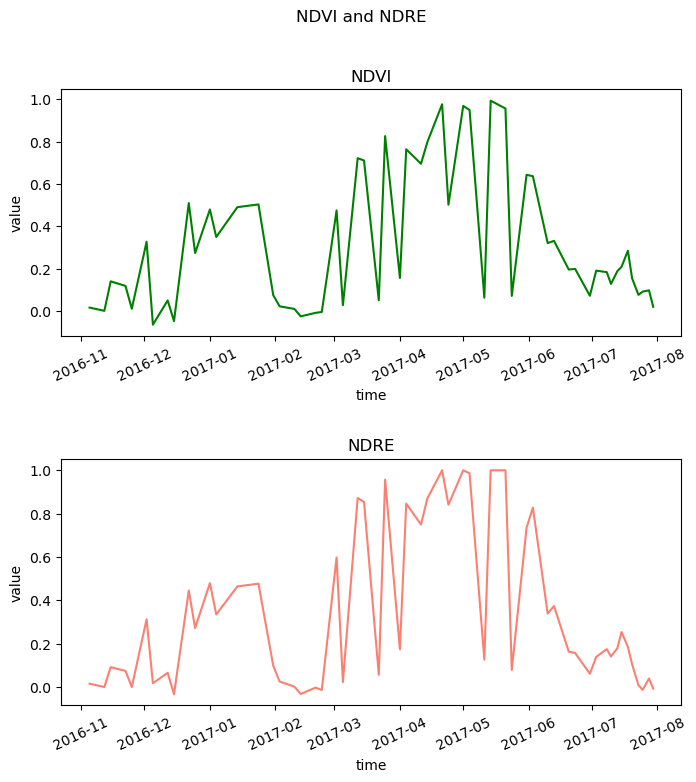

In [93]:
date = []
for a in img_list:
    date.append(datetime.strptime(a,"%Y-%m-%d"))

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))
plt.subplots_adjust(hspace=0.5)
fig.suptitle('NDVI and NDRE')
plt.sca(axs[0])
plt.xticks(rotation=25) # Rotate label


print(NDVI.shape)
axs[0].plot(date,NDVI[:,13,43],color="green")
axs[0].set_title("NDVI")
axs[0].set_xlabel("time")
axs[0].set_ylabel("value")

axs[1].plot(date,NDVI[:,30,30],color="salmon")
axs[1].set_title("NDRE")
axs[1].set_xlabel("time")
axs[1].set_ylabel("value")
plt.sca(axs[1])
plt.xticks(rotation=25)
plt.show()

# Using Lowess Smoother to smoothout the NDVI curve

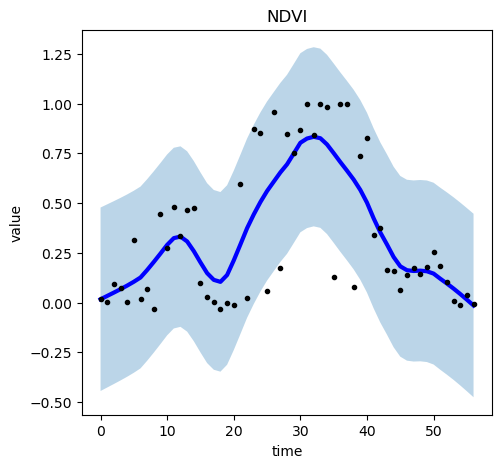

In [89]:
from tsmoothie.utils_func import sim_randomwalk
from tsmoothie.smoother import LowessSmoother
NDVIfilter = NDVI[:,30,30]

# operate smoothing
smoother = LowessSmoother(smooth_fraction=0.2, iterations=1)
smoother.smooth(NDVIfilter)

# generate intervals
low, up = smoother.get_intervals('prediction_interval')

# plot the smoothed timeseries with intervals
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.plot(smoother.smooth_data[i], linewidth=3, color='blue')
plt.plot(smoother.data[0], '.k')
plt.title("NDVI"); plt.xlabel('time');plt.ylabel('value')

plt.fill_between(range(len(smoother.data[0])), low[0], up[0], alpha=0.3)

# Plot the result for one curve

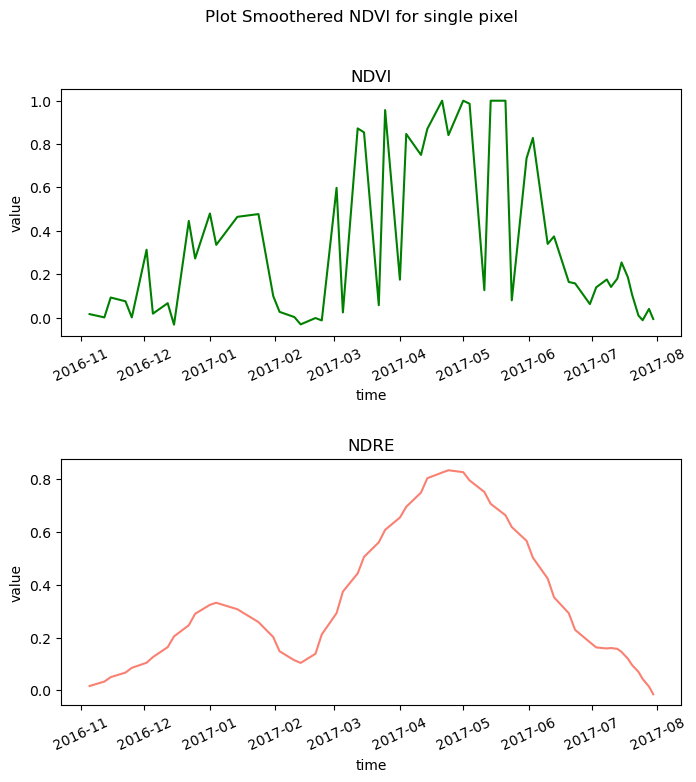

In [96]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))
fig.suptitle('Plot Smoothered NDVI for single pixel')
plt.sca(axs[0])
plt.subplots_adjust(hspace=0.5)
plt.xticks(rotation=25)
NDVIfilter = NDVI[:,30,30]
axs[0].plot(date,NDVIfilter,color="green")
axs[0].set_title("NDVI")
axs[0].set_xlabel("time")
axs[0].set_ylabel("value")

axs[1].plot(date,smoother.smooth_data[0],color="salmon")
axs[1].set_title("NDRE")
axs[1].set_xlabel("time")
axs[1].set_ylabel("value")
plt.sca(axs[1])
plt.xticks(rotation=25)
plt.show()

# With good result on one curve, now we proceeds to smoothing all pixels

# Plot the result of all pixels

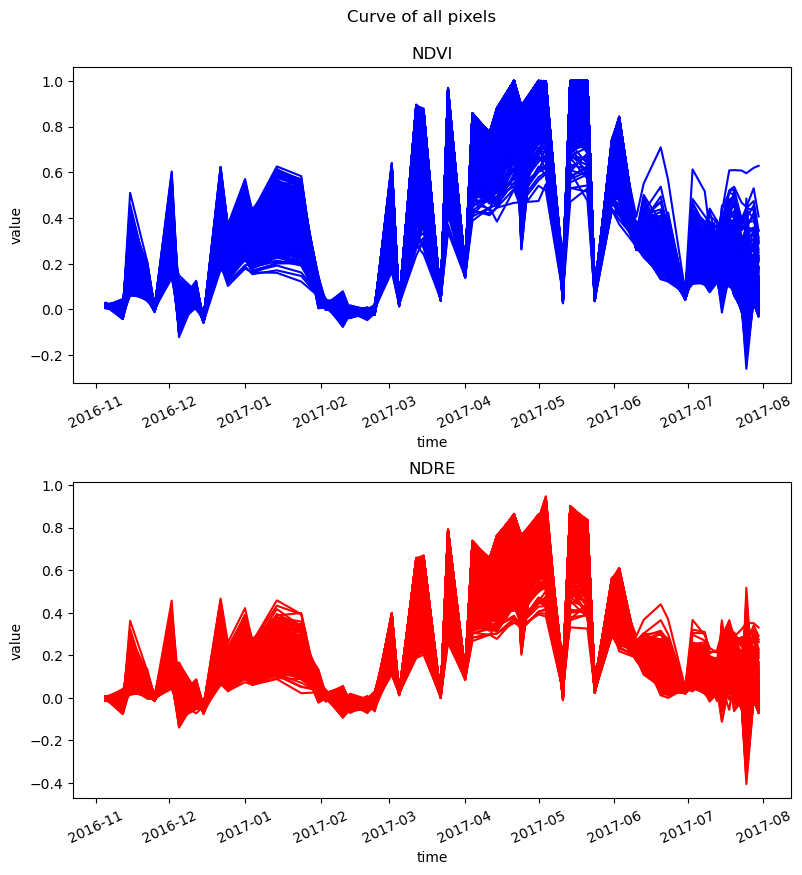

In [64]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(9, 9))
fig.suptitle('Curve of all pixels')
fig.tight_layout(pad=5.0)
plt.sca(axs[0])
plt.title('NDVI')
plt.xticks(rotation=25) # Needed for rotating the date labels
validePixelNDVI = []
validePixelNDRE = []
for a in range(NDVI.shape[1]):
    for b in range(NDVI.shape[2]):
        if(np.sum(NDVI[:,a,b] != 0)):
            validePixelNDVI.append(NDVI[:,a,b])
            validePixelNDRE.append(NDRE[:,a,b])
        #axs.plot(date,NDVI[:,a,b],color='blue')

for a in range(len(validePixelNDVI)):
    axs[0].plot(date,validePixelNDVI[a],color='blue')
    axs[0].set_xlabel("time")
    axs[0].set_ylabel("value")

for a in range(len(validePixelNDRE)):
    axs[1].plot(date,validePixelNDRE[a],color='red')
    axs[1].set_xlabel("time")
    axs[1].set_ylabel("value")

plt.sca(axs[1])
plt.title('NDRE')
plt.xticks(rotation=25)
plt.show()

# Box plot of NDVI and NDRE

# Prepare the skdfa datastructure (FDataGrid)

In [31]:
import matplotlib.pyplot as plt

import skfda
from skfda.datasets import fetch_growth
from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import (
    BSplineBasis,
    FourierBasis,
    MonomialBasis,
)

img_list.index('2017-02-13')
img_list.index('2017-07-15')
NDVI_cut = NDVI[18:50,:,:]
NDRE_cut = NDRE[18:50,:,:]
print(NDVI_cut.shape)
print(NDRE_cut.shape)

dataset = skfda.datasets.fetch_growth()
fd = dataset['data']
print(type(fd))
y = dataset['target']


(32, 56, 72)
(32, 56, 72)
<class 'skfda.representation.grid.FDataGrid'>


# Execute the plot

# NDVI

[43, 50, 53, 60, 63, 70, 73, 80, 83, 90, 93, 100, 103, 110, 113, 120, 123, 130, 133, 140, 143, 150, 153, 160, 163, 170, 173, 180, 183, 188, 190, 193]



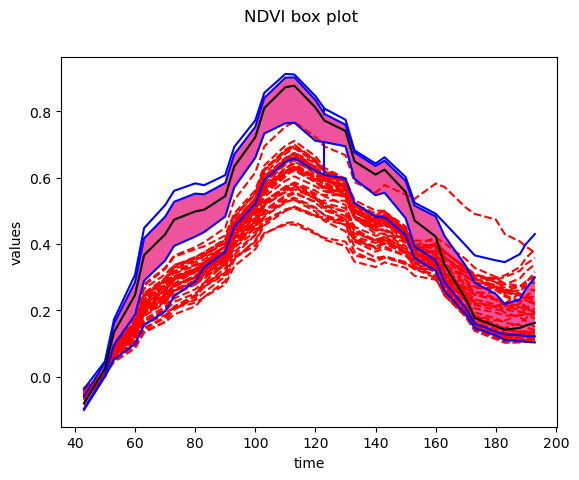

In [63]:
import skfda
from skfda import datasets
from skfda.exploratory.depth import ModifiedBandDepth, IntegratedDepth
from skfda.exploratory.visualization import Boxplot

smoother = LowessSmoother(smooth_fraction=0.2, iterations=1) # Mi serve per smussare le curve

days = []
zeroDay = datetime.strptime("2017-01-01","%Y-%m-%d")
date_cut = date[18:50]
for a in date_cut:
    days.append((a-zeroDay).days)

print(days)

grid_points = days  # Grid points of the curves
data_matrixNDVI = []
for a in range(NDVI_cut.shape[1]):
    for b in range(NDVI_cut.shape[2]):
        if(np.sum(NDVI[:,a,b] != 0)):
            '''smoother.smooth(NDVI_cut[:,a,b]).smooth_data
            print(smoother.smooth(NDVI_cut[:,a,b]).smooth_data[0])'''
            data_matrixNDVI.append(smoother.smooth(NDVI_cut[:,a,b]).smooth_data[0])


fd_NDVI = skfda.FDataGrid(
    data_matrix=data_matrixNDVI,
    grid_points=grid_points,
    dataset_name="NDVI box plot",
    argument_names=('time',),
    coordinate_names=('values',)
)

fdBoxplot = Boxplot(fd_NDVI)
fdBoxplot.show_full_outliers = True
fdBoxplot.plot()
print() # need for avoid duplicate plot


# NDRE

[43, 50, 53, 60, 63, 70, 73, 80, 83, 90, 93, 100, 103, 110, 113, 120, 123, 130, 133, 140, 143, 150, 153, 160, 163, 170, 173, 180, 183, 188, 190, 193]



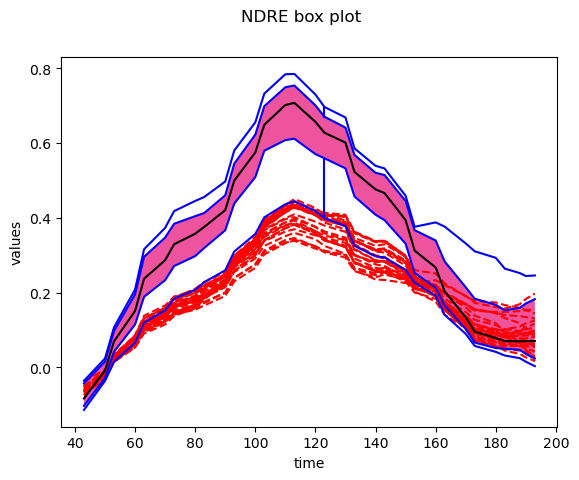

In [62]:
smoother = LowessSmoother(smooth_fraction=0.2, iterations=1) # Mi serve per smussare le curve

days = []
date_cut = date[18:50]
for a in date_cut:
    days.append((a-zeroDay).days)

print(days)

grid_points = days  # Grid points of the curves
data_matrixNDRE = []
for a in range(NDRE_cut.shape[1]):
    for b in range(NDRE_cut.shape[2]):
        if(np.sum(NDVI[:,a,b] != 0)): # the filter condition is same with NDVI
            data_matrixNDRE.append(smoother.smooth(NDRE_cut[:,a,b]).smooth_data[0])


fd_NDRE = skfda.FDataGrid(
    data_matrix=data_matrixNDRE,
    grid_points=grid_points,
    dataset_name="NDRE box plot",
    argument_names=('time',),
    coordinate_names=('values',)
)

fdBoxplot = Boxplot(fd_NDRE)
fdBoxplot.show_full_outliers = True
fdBoxplot.plot()
print() # need for avoid duplicate plot

# Using FPCA to obtain main compoments

In [36]:
import skfda
from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import (
    BSplineBasis,
    FourierBasis,
    MonomialBasis,
)
fpca_discretized = FPCA(n_components=2)
basis = skfda.representation.basis.BSplineBasis(n_basis=7)

# NDVI

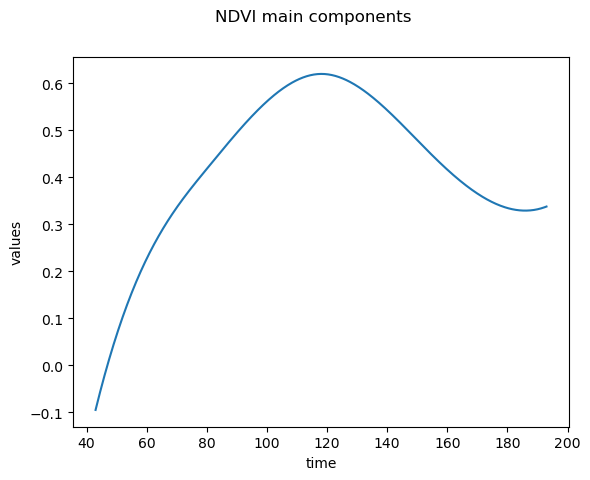

In [61]:

fpca_discretized.fit(fd_NDVI.to_basis(basis=basis))
sommaNDVI = fpca_discretized.components_[0]+fpca_discretized.components_[1]+fpca_discretized.mean_
sommaNDVI.dataset_name='NDVI main components'
sommaNDVI.coordinate_names=('values',)
sommaNDVI.argument_names=('time',)
sommaNDVI.plot()
print() # need for avoid duplicate plot

# NDRE

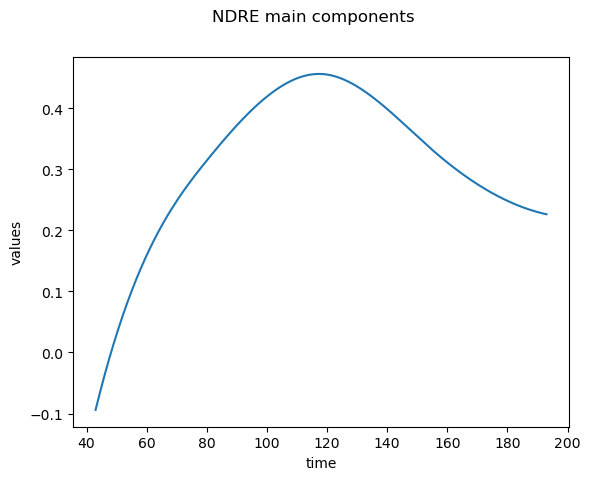

In [97]:

fpca_discretized.fit(fd_NDRE.to_basis(basis=basis))
sommaNDRE = fpca_discretized.components_[0]+fpca_discretized.components_[1]+fpca_discretized.mean_
sommaNDRE.dataset_name='NDRE main components'
sommaNDRE.coordinate_names=('values',)
sommaNDRE.argument_names=('time',)
sommaNDRE.plot()
print() # need for avoid duplicate plot

In [98]:
newSeriesNDVI = []
newSeriesNDRE = []
rangeNewGridPoint = range(grid_points[0],grid_points[len(grid_points)-1])

for b in range(len(data_matrixNDVI)):
    newSeriesNDVI.append([])
    newSeriesNDRE.append([])

for a in rangeNewGridPoint:
    try:
        i = grid_points.index(a)
        for c in range(len(data_matrixNDVI)):
            newSeriesNDVI[c].append(data_matrixNDVI[c][i])
            newSeriesNDRE[c].append(data_matrixNDRE[c][i])
    except:
        for c in range(len(data_matrixNDVI)):
            newSeriesNDVI[c].append(sommaNDVI(a)[0][0][0])
            newSeriesNDRE[c].append(sommaNDRE(a)[0][0][0])




# Smooth and plot the result

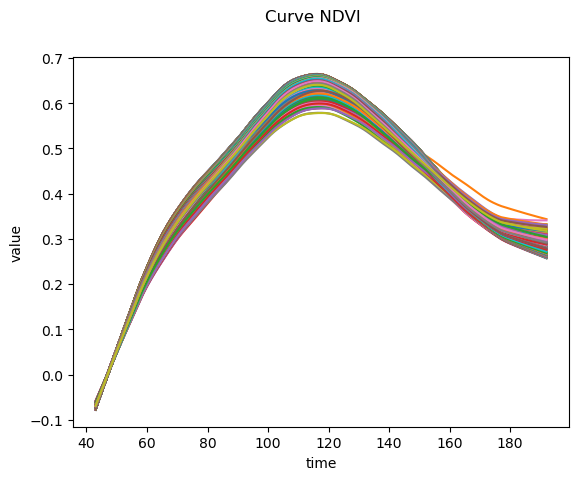

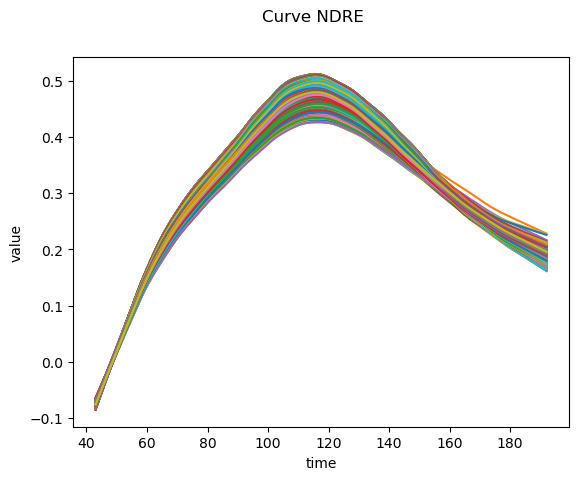

In [57]:
NewMatrixNDVI = []
NewMatrixNDRE = []
for b in range(len(data_matrixNDVI)):
    NewMatrixNDVI.append([])
    NewMatrixNDVI[b] = smoother.smooth(newSeriesNDVI[b]).smooth_data[0]
    NewMatrixNDRE.append([])
    NewMatrixNDRE[b] = smoother.smooth(newSeriesNDRE[b]).smooth_data[0]

fd_NDVI_New = skfda.FDataGrid(
    data_matrix=NewMatrixNDVI,
    grid_points=rangeNewGridPoint,
    dataset_name="Curve NDVI",
    coordinate_names=('value',),
    argument_names=('time',)
)
fd_NDVI_New.plot()

fd_NDRE_New = skfda.FDataGrid(
    data_matrix=NewMatrixNDRE,
    grid_points=rangeNewGridPoint,
    dataset_name="Curve NDRE",
    coordinate_names=('value',),
    argument_names=('time',)
)
fd_NDRE_New.plot()

print() # need for avoid duplicate plot

# Save the result in Pickle

In [58]:
import pickle

with open('./pickles/ndvi.pickle', 'wb') as handle:
    pickle.dump(fd_NDVI_New, handle, protocol=pickle.HIGHEST_PROTOCOL)
    handle.close()

with open('./pickles/ndre.pickle', 'wb') as handle:
    pickle.dump(fd_NDRE_New, handle, protocol=pickle.HIGHEST_PROTOCOL)
    handle.close()